In [ ]:
from pyiron import Project
import numpy as np
import matplotlib.pylab as plt
%config InlineBackend.figure_format = 'retina'

In [ ]:
import seaborn as sns

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
pr = Project('ELASTIC')

# Try a constant volume cell shape optimization in Lammps

\begin{align}
\mathcal L = F - \lambda l_xl_yl_z \\
\frac{\partial F}{\partial l_i} - \lambda l_jl_k = 0\\
\frac{p_x}{l_yl_z}=\frac{p_y}{l_xl_z}=\frac{p_z}{l_xl_y}
\end{align}

In [21]:
import scipy.optimize as so

In [24]:
s = pr.create.structure.bulk('Mg', orthorhombic=True)

In [25]:
s

Mg: [0. 0. 0.]
Mg: [1.605      2.77994155 0.        ]
Mg: [1.605      0.92664718 2.60652   ]
Mg: [0.         3.70658873 2.60652   ]
pbc: [ True  True  True]
cell: 
Cell([3.21, 5.559883092296095, 5.21304])

In [ ]:
s.set_cell(

In [122]:
def make(lmp):
    s = lmp.structure.copy()
    V = s.get_volume()
    def objective(x0):
        lx, ly = x0
        lz = V / lx / ly
        s.set_cell([lx, ly, lz], scale_atoms=True)
        lmp.structure = s
        lmp.run()
        e = lmp.output.energy_pot[-1]
        #print(lx, ly, lz, V - lx*ly*lz, e)
        return e
    return objective

In [165]:
j = pr.create.job.Lammps('cell_shape_min', delete_existing_job=True)
j.structure = pr.create.structure.bulk('Mg', orthorhombic=True)
j.calc_static()
j.interactive_enforce_structure_reset = True

In [124]:
j.interactive_open()

Interactive ready

In [125]:
j.structure.cell

Cell([3.21, 5.559883092296095, 5.21304])

In [126]:
j.structure.plot3d()

NGLWidget()

In [90]:
res = so.minimize(
    make(j), x0=(j.structure.cell.array[0, 0], j.structure.cell.array[1, 1])
)

The job cell_shape_min was saved and received the ID: 35
3.21 5.559883092296095 5.213039999999998 1.4210854715202004e-14 -6.037981316143484
3.210000014901161 5.559883092296095 5.213039975800513 0.0 -6.0379813162292955
3.21 5.5598831071972565 5.213039986028418 0.0 -6.037981316193033
3.2157587027549743 5.56320825661418 5.200594327553633 0.0 -6.037904306150528
3.2157587176561355 5.56320825661418 5.200594303455154 -1.4210854715202004e-14 -6.037904305736081
3.2157587027549743 5.563208271515341 5.20059431362374 0.0 -6.037904305984074
3.2110444453067815 5.560486171220997 5.210779160810564 0.0 -6.037985318752172
3.2110444602079427 5.560486171220997 5.210779136629442 -1.4210854715202004e-14 -6.037985318746336
3.2110444453067815 5.560486186122159 5.2107791468465585 0.0 -6.037985318762111
3.2107349024969642 5.561199804143225 5.210612795141941 -1.4210854715202004e-14 -6.037985606388932
3.2107349173981254 5.561199804143225 5.210612770959259 0.0 -6.037985606389161
3.2107349024969642 5.56119981904438

In [83]:
res

      fun: -6.037985606766677
 hess_inv: array([[ 0.28962988, -0.27757114],
       [-0.27757114,  0.86992752]])
      jac: array([-2.38418579e-07, -5.96046448e-08])
  message: 'Optimization terminated successfully.'
     nfev: 15
      nit: 3
     njev: 5
   status: 0
  success: True
        x: array([3.21074587, 5.56117511])

In [193]:
def calc_cell_of_V(j, vrange):
    R = []
    Ri = []
    for v in vrange:
        j.structure = j.structure.apply_strain( (v/j.structure.get_volume())**(1/3) - 1, return_box=True)
        Ri.append(np.diag(j.structure.cell.array))
        res = so.minimize(
            make(j), x0=(j.structure.cell.array[0, 0], j.structure.cell.array[1, 1])
        )
        R.append([*res.x, v/res.x.prod()]) 
    return vrange, np.array(R), np.array(Ri)

In [234]:
jmin = pr.create.job.Lammps('structure_min', delete_existing_job=True)
jmin.structure = pr.create.structure.bulk('Mg', orthorhombic=True)
jmin.calc_minimize(pressure=[0]*3)
jmin.run()

/srv/conda/envs/notebook/lib/python3.7/site-packages/pyiron_atomistics/lammps/base.py:259: UserWarning: No potential set via job.potential - use default potential, 1997--Liu-X-Y--Al-Mg--LAMMPS--ipr1
  warnings.warn("No potential set via job.potential - use default potential, " + lst_of_potentials[0])


The job structure_min was saved and received the ID: 79


In [235]:
structure0 = jmin.get_structure()

In [294]:
j = pr.create.job.Lammps('cell_shape_min', delete_existing_job=True)
j.structure = structure0
j.calc_static()
j.interactive_enforce_structure_reset = True

In [295]:
j.interactive_open()

Interactive ready

In [296]:
R0 = np.diag(j.structure.cell.array)

In [297]:
vrange, R, Ri = calc_cell_of_V(j, j.structure.get_volume() * np.linspace(1, 1.04, 25))

/srv/conda/envs/notebook/lib/python3.7/site-packages/pyiron_atomistics/lammps/base.py:259: UserWarning: No potential set via job.potential - use default potential, 1997--Liu-X-Y--Al-Mg--LAMMPS--ipr1
  warnings.warn("No potential set via job.potential - use default potential, " + lst_of_potentials[0])


The job cell_shape_min was saved and received the ID: 131


In [298]:
j.output.energy_pot.shape

(282,)

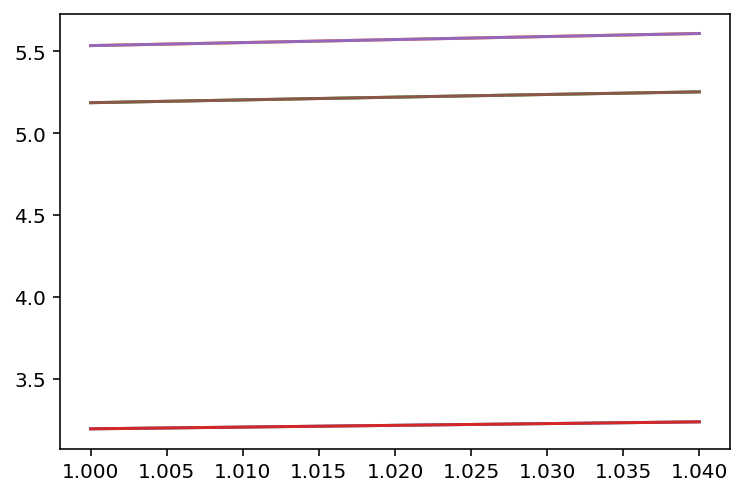

In [243]:
plt.plot(vrange/np.prod(R0), R, vrange/np.prod(R0), Ri)

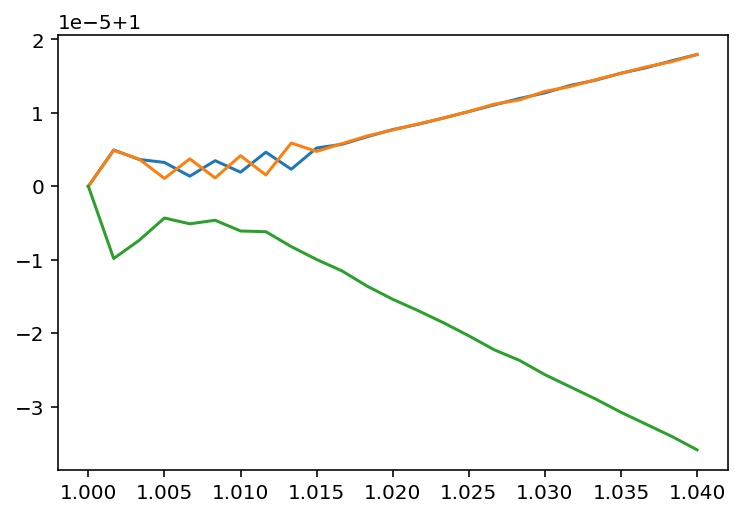

In [244]:
plt.plot(vrange/np.prod(R0), R/Ri)

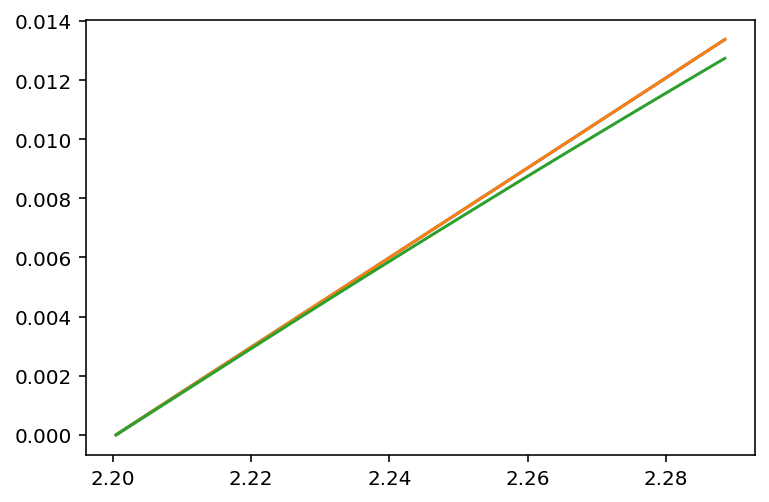

In [245]:
plt.plot(vrange/np.prod(R0 - 1), R/R0 - 1)

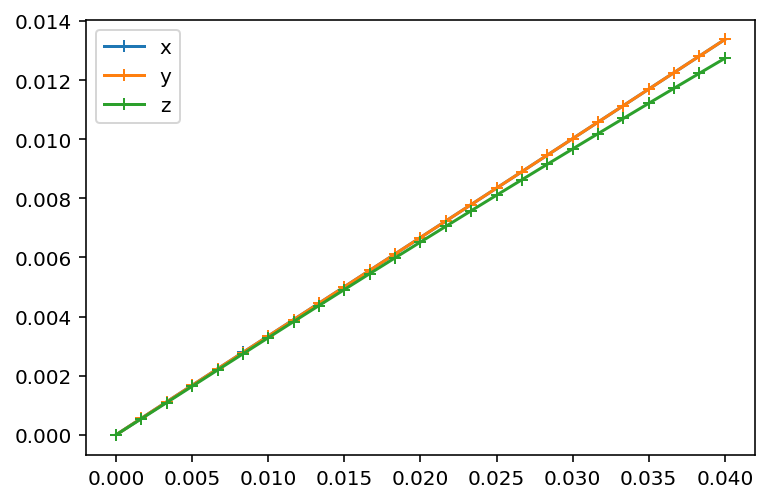

In [285]:
plt.plot(vrange/np.prod(R0) - 1, R/R0 - 1, marker='+',label=['x','y','z'])
plt.legend()

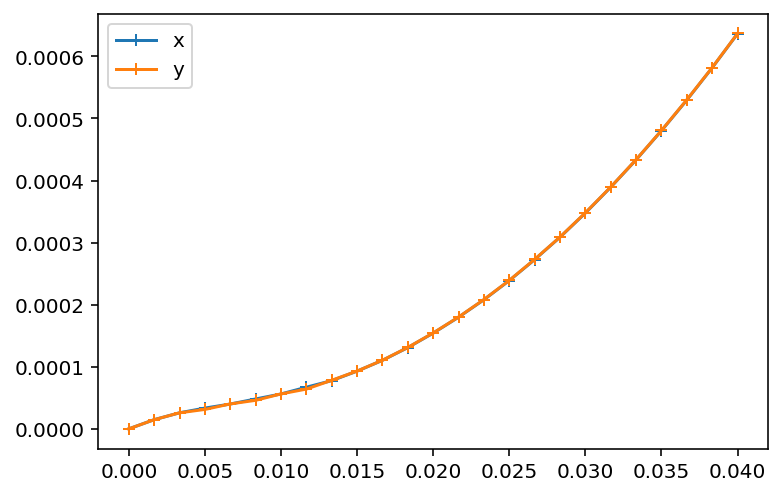

In [309]:
plt.plot(vrange/np.prod(R0) - 1, (R/R0)[:,[0,1]] - (R/R0)[:,2][:, None], marker='+',label=['x','y'])
plt.legend()

In [272]:
np.diag(structure0.cell)

array([3.19599999, 5.53563437, 5.18711088])

In [252]:
structure0.repeat(3).plot3d()

NGLWidget()

# Three Steps from Paper
https://iopscience.iop.org/article/10.1088/0953-8984/22/22/225404/pdf

0. Minimize Structure
1. Quasi Harmonic to get V(T, P)
2. Steps from above to get R(V)
3. Run ElasticTensor as R(V(T)) -> approximate that as finite temperature elastic constants

# Sam's sphere

In [ ]:
from sklearn.linear_model import LinearRegression

In [299]:
epsilon_lst = np.linspace(-0.01, 0.01, 3)
strain_lst = np.stack(np.meshgrid(* 2 * (epsilon_lst,)), axis=-1).reshape(-1, 2)
ratio_lst = strain_lst + 1
all_strain_lst = np.concatenate((ratio_lst, 1 / np.prod(ratio_lst, axis=-1).reshape(-1, 1)), axis=-1) - 1
strain_polynomial = np.concatenate((strain_lst, strain_lst**2, 2 * np.prod(strain_lst, axis=-1).reshape(-1, 1)), axis=-1)

In [308]:
original_structure = jmin.get_structure()
eps_range = np.linspace(1, 1.04, 10) - 1

In [317]:
min_strain_lst = []
for eps in eps_range:
    job = pr.create.job.Lammps(('sams_idea', eps), delete_existing_job=True)
    job.calc_static()
    with job.interactive_open() as lmp:
        for strain in all_strain_lst:
            lmp.structure = original_structure.apply_strain(eps, return_box=True)
            lmp.structure.apply_strain(strain)
            lmp.run()
    reg = LinearRegression()
    E = job['output/generic/energy_pot']
    reg.fit(strain_polynomial, E)
    min_strain_lst.append(-np.matmul(np.linalg.inv(reg.coef_[[2, 4, 4, 3]].reshape(2, 2)), reg.coef_[:2]))

/srv/conda/envs/notebook/lib/python3.7/site-packages/pyiron_atomistics/lammps/base.py:259: UserWarning: No potential set via job.potential - use default potential, 1997--Liu-X-Y--Al-Mg--LAMMPS--ipr1
  warnings.warn("No potential set via job.potential - use default potential, " + lst_of_potentials[0])


The job sams_idea_0d0 was saved and received the ID: 152


/srv/conda/envs/notebook/lib/python3.7/site-packages/pyiron_atomistics/lammps/base.py:259: UserWarning: No potential set via job.potential - use default potential, 1997--Liu-X-Y--Al-Mg--LAMMPS--ipr1
  warnings.warn("No potential set via job.potential - use default potential, " + lst_of_potentials[0])


The job sams_idea_0d00444444 was saved and received the ID: 153


/srv/conda/envs/notebook/lib/python3.7/site-packages/pyiron_atomistics/lammps/base.py:259: UserWarning: No potential set via job.potential - use default potential, 1997--Liu-X-Y--Al-Mg--LAMMPS--ipr1
  warnings.warn("No potential set via job.potential - use default potential, " + lst_of_potentials[0])


The job sams_idea_0d00888889 was saved and received the ID: 154


/srv/conda/envs/notebook/lib/python3.7/site-packages/pyiron_atomistics/lammps/base.py:259: UserWarning: No potential set via job.potential - use default potential, 1997--Liu-X-Y--Al-Mg--LAMMPS--ipr1
  warnings.warn("No potential set via job.potential - use default potential, " + lst_of_potentials[0])


The job sams_idea_0d01333333 was saved and received the ID: 155


/srv/conda/envs/notebook/lib/python3.7/site-packages/pyiron_atomistics/lammps/base.py:259: UserWarning: No potential set via job.potential - use default potential, 1997--Liu-X-Y--Al-Mg--LAMMPS--ipr1
  warnings.warn("No potential set via job.potential - use default potential, " + lst_of_potentials[0])


The job sams_idea_0d01777778 was saved and received the ID: 156


/srv/conda/envs/notebook/lib/python3.7/site-packages/pyiron_atomistics/lammps/base.py:259: UserWarning: No potential set via job.potential - use default potential, 1997--Liu-X-Y--Al-Mg--LAMMPS--ipr1
  warnings.warn("No potential set via job.potential - use default potential, " + lst_of_potentials[0])


The job sams_idea_0d02222222 was saved and received the ID: 157


/srv/conda/envs/notebook/lib/python3.7/site-packages/pyiron_atomistics/lammps/base.py:259: UserWarning: No potential set via job.potential - use default potential, 1997--Liu-X-Y--Al-Mg--LAMMPS--ipr1
  warnings.warn("No potential set via job.potential - use default potential, " + lst_of_potentials[0])


The job sams_idea_0d02666667 was saved and received the ID: 158


/srv/conda/envs/notebook/lib/python3.7/site-packages/pyiron_atomistics/lammps/base.py:259: UserWarning: No potential set via job.potential - use default potential, 1997--Liu-X-Y--Al-Mg--LAMMPS--ipr1
  warnings.warn("No potential set via job.potential - use default potential, " + lst_of_potentials[0])


The job sams_idea_0d03111111 was saved and received the ID: 159


/srv/conda/envs/notebook/lib/python3.7/site-packages/pyiron_atomistics/lammps/base.py:259: UserWarning: No potential set via job.potential - use default potential, 1997--Liu-X-Y--Al-Mg--LAMMPS--ipr1
  warnings.warn("No potential set via job.potential - use default potential, " + lst_of_potentials[0])


The job sams_idea_0d03555556 was saved and received the ID: 160


/srv/conda/envs/notebook/lib/python3.7/site-packages/pyiron_atomistics/lammps/base.py:259: UserWarning: No potential set via job.potential - use default potential, 1997--Liu-X-Y--Al-Mg--LAMMPS--ipr1
  warnings.warn("No potential set via job.potential - use default potential, " + lst_of_potentials[0])


The job sams_idea_0d04 was saved and received the ID: 161


In [311]:
min_strain_lst = np.array(min_strain_lst)

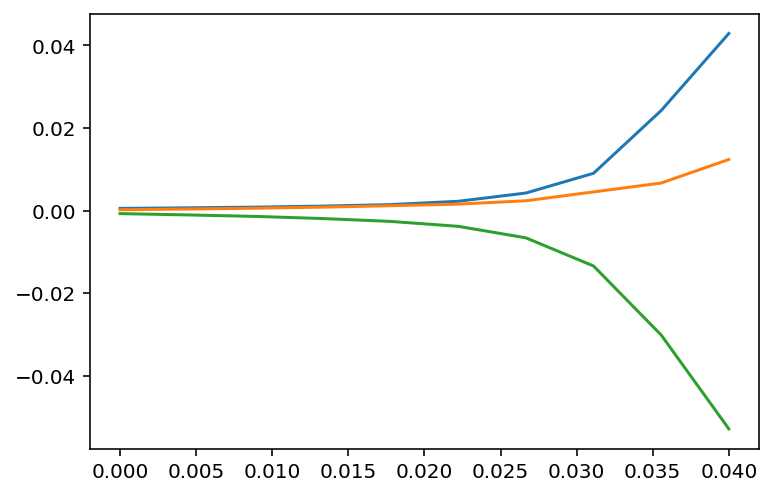

In [312]:
plt.plot(eps_range, min_strain_lst)
plt.plot(eps_range, 1 / np.prod(min_strain_lst + 1, axis=-1) - 1)

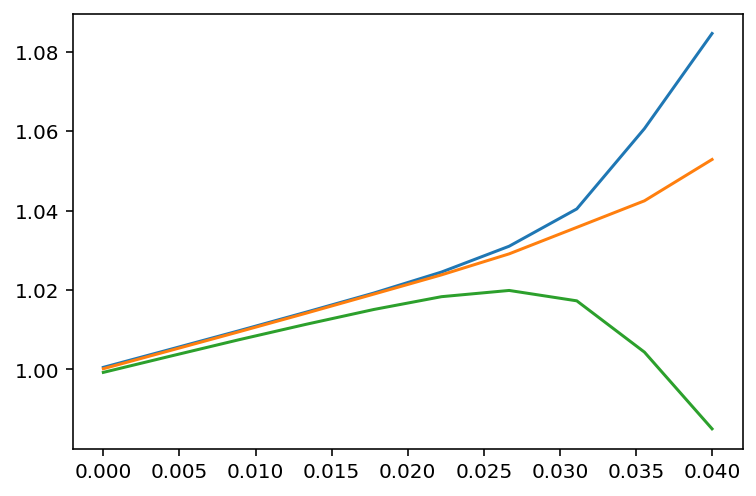

In [313]:
plt.plot(eps_range, (1 + min_strain_lst) * (1 + eps_range)[:, None])
plt.plot(eps_range, (1 + eps_range) / np.prod(min_strain_lst + 1, axis=-1))

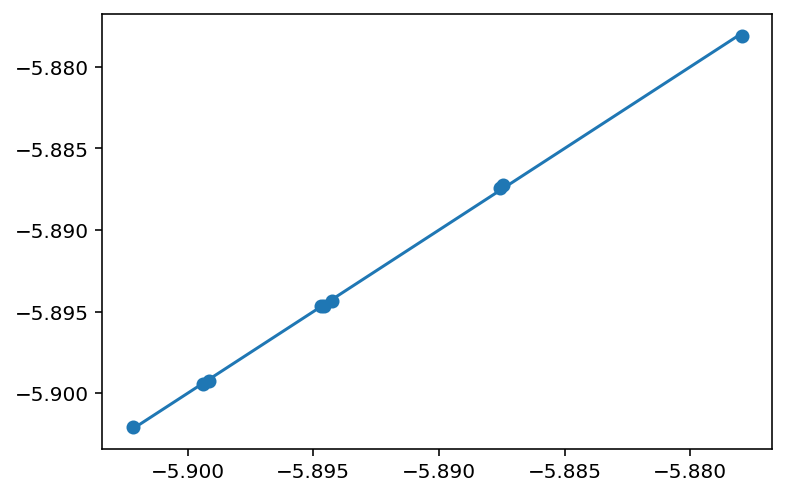

In [315]:
plt.scatter(E, np.sum(strain_polynomial * reg.coef_, axis=-1) + reg.intercept_)
plt.plot(* 2 * [[E.min(), E.max()]])

array([0.00123912, 0.00028524])